# Load Data

In [1]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir, read_unlabeled_data
from utils import TAG2IDX, IDX2TAG, DATA_DIR, POS_FINE_DIR, UNLABELED_DIR
from utils import MODEL_DIR, INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR
# from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, UnlabeledDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train_one_epoch, eval

from analysis import save_sns_fig, analysis_output, make_plot_metric

from create_pseudo_data import gen_pseudo_data_by_unlabel

import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)

import time


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


base: 

- Train: 
  - size: 30060, lr: 0.0001
- Val
  - size: 1336, lr: 0.001


In [3]:
def run_supservised_learning(domain, lr):
  print("=========================================================")
  print("Create directories")
  (sub_model_dir, sub_metrics_dir, sub_result_dir, 
    sub_int_res_dir) = create_sub_dir(domain, method_name="Zero_shot_learning")

  print("=========================================================")
  print("Load data")
  ul_domain_file = os.path.join(UNLABELED_DIR, f"gweb-{domain}.unlabeled.txt")

  domain_dir = os.path.join(POS_FINE_DIR, f"{domain}")
  domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
  domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

  domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
  domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)

  domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
  domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

  dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)
  test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

  dev_iter = data.DataLoader(
      dataset=dev_dataset,
      batch_size=8,
      shuffle=True,
      num_workers=1,
      collate_fn=pad)
  test_iter = data.DataLoader(
      dataset=test_dataset,
      batch_size=8,
      shuffle=False,
      num_workers=1,
      collate_fn=pad)


  model_name = [name for name in os.listdir(MODEL_DIR) if "base_model_" in name][0]
  model_file = os.path.join(MODEL_DIR, model_name)
  print(model_file)

  model = Net(vocab_size=len(TAG2IDX))
  model.to(DEVICE)
  model = nn.DataParallel(model)
  model.load_state_dict(torch.load(model_file))

  print("=========================================================")
  print("Test base model")

  avg_domain_prec_lst = []
  avg_domain_rec_lst = []
  avg_domain_f1_lst = []
  avg_domain_acc_lst = []

  micro_domain_prec_lst = []
  micro_domain_rec_lst = []
  micro_domain_f1_lst = []
  micro_domain_acc_lst = []

  macro_domain_prec_lst = []
  macro_domain_rec_lst = []
  macro_domain_f1_lst = []
  macro_domain_acc_lst = []

  output_res_file = os.path.join(sub_result_dir, f"{domain}-lr{lr}.txt")
  (test_prec_avg, test_rec_avg, test_f1_avg, acc_avg, 
    test_prec_micro, test_rec_micro, test_f1_micro, test_acc_micro, 
    test_prec_macro, test_rec_macro, test_f1_macro, test_acc_macro) = eval(
      model, test_iter, save_output=True, output_file=output_res_file)

  csv_file_name = os.path.join(sub_result_dir, f"{domain}-lr{lr}.csv")
  output_plot_name = os.path.join(sub_result_dir, f"{domain}-lr{lr}.png")

  _ = analysis_output(
      output_res_file, csvsave=True, pngsave=True, 
      csv_file_name=csv_file_name, output_plot_name=output_plot_name, 
      figtitle=f"{domain}-lr{lr} Test: Accuracy for each tag")

  avg_domain_prec_lst.append(test_prec_avg.item())
  avg_domain_rec_lst.append(test_rec_avg.item())
  avg_domain_f1_lst.append(test_f1_avg.item())
  avg_domain_acc_lst.append(acc_avg.item())

  micro_domain_prec_lst.append(test_prec_micro.item())
  micro_domain_rec_lst.append(test_rec_micro.item())
  micro_domain_f1_lst.append(test_f1_micro.item())
  micro_domain_acc_lst.append(test_acc_micro.item())

  macro_domain_prec_lst.append(test_prec_macro.item())
  macro_domain_rec_lst.append(test_rec_macro.item())
  macro_domain_f1_lst.append(test_f1_macro.item())
  macro_domain_acc_lst.append(test_acc_macro.item())

  print("=========================================================")
  print("Start training")

  epoch_number = 0
  EPOCHS = 1

  best_vloss = 1_000_000.

  optimizer = optim.Adam(model.parameters(), lr = lr)
  loss_fn = nn.CrossEntropyLoss(ignore_index=0)

  for epoch in range(EPOCHS):
      print('  EPOCH {}:'.format(epoch_number + 1))

      model.train(True)
      avg_loss = train_one_epoch(model, dev_iter, optimizer, loss_fn, epoch_number)

      print('  LOSS train {}'.format(avg_loss))

      epoch_number += 1


  print("=========================================================")
  print("Test zero shot model")
  output_res_file = os.path.join(sub_result_dir, f"{domain}-lr{lr}.txt")

  (test_prec_avg, test_rec_avg, test_f1_avg, acc_avg, 
    test_prec_micro, test_rec_micro, test_f1_micro, test_acc_micro, 
    test_prec_macro, test_rec_macro, test_f1_macro, test_acc_macro) = eval(
      model, test_iter, save_output=True, output_file=output_res_file)

  avg_domain_prec_lst.append(test_prec_avg.item())
  avg_domain_rec_lst.append(test_rec_avg.item())
  avg_domain_f1_lst.append(test_f1_avg.item())
  avg_domain_acc_lst.append(acc_avg.item())

  micro_domain_prec_lst.append(test_prec_micro.item())
  micro_domain_rec_lst.append(test_rec_micro.item())
  micro_domain_f1_lst.append(test_f1_micro.item())
  micro_domain_acc_lst.append(test_acc_micro.item())

  macro_domain_prec_lst.append(test_prec_macro.item())
  macro_domain_rec_lst.append(test_rec_macro.item())
  macro_domain_f1_lst.append(test_f1_macro.item())
  macro_domain_acc_lst.append(test_acc_macro.item())


  csv_file_name = os.path.join(sub_result_dir, f"{domain}-lr{lr}.csv")
  output_plot_name = os.path.join(sub_result_dir, f"{domain}-lr{lr}.png")

  _ = analysis_output(
      output_res_file, csvsave=True, pngsave=True, 
      csv_file_name=csv_file_name, output_plot_name=output_plot_name, 
      figtitle=f"{domain}-lr{lr} Test: Accuracy for each tag")


  print("=========================================================")
  print("Plot compare result")

  metrics_df = pd.DataFrame({
      f"{domain}_weighted_prec_lst": avg_domain_prec_lst,
      f"{domain}_weighted_rec_lst": avg_domain_rec_lst,
      f"{domain}_weighted_f1_lst": avg_domain_f1_lst,
      f"{domain}_weighted_acc_lst": avg_domain_acc_lst,

      f"{domain}_micro_prec_lst": micro_domain_prec_lst,
      f"{domain}_micro_rec_lst": micro_domain_rec_lst,
      f"{domain}_micro_f1_lst": micro_domain_f1_lst,
      f"{domain}_micro_acc_lst": micro_domain_acc_lst,

      f"{domain}_macro_prec_lst": macro_domain_prec_lst,
      f"{domain}_macro_rec_lst": macro_domain_rec_lst,
      f"{domain}_macro_f1_lst": macro_domain_f1_lst,
      f"{domain}_macro_acc_lst": macro_domain_acc_lst

  })


  print("=========================================================")
  print("Plot and save metrics")

  base_model_scores = metrics_df.iloc[0].tolist()
  zero_shot_scores = metrics_df.iloc[1].tolist()
  scores_names = metrics_df.columns.tolist()

  fig = plt.figure(figsize=(20,6))

  sns.lineplot(x=scores_names, y=base_model_scores)
  sns.scatterplot(x=scores_names, y=base_model_scores, label="Zero shot")
  sns.lineplot(x=scores_names, y=zero_shot_scores)
  sns.scatterplot(x=scores_names, y=zero_shot_scores, label="Supervised learning")
  plt.xticks(rotation=45, size=10)
  plt.title(f"{domain}-lr{lr}")

  metric_name = os.path.join(sub_metrics_dir, f"{domain}-lr{lr}.png")
  fig.savefig(metric_name)


In [4]:
DOMAIN_LST = ["answers", "emails", "newsgroups", "reviews", "weblogs"]
lr_lst = [0.001, 0.0001]

Create directories
Load data
The number of samples: 1745
The number of tags 49
The number of samples: 1744
The number of tags 50
after filter tag 1713
after filter tag 1723
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0
Test base model
Start training
  EPOCH 1:
  LOSS train 0.0
Test zero shot model
Plot compare result
Plot and save metrics
Create directories
Load data
The number of samples: 1745
The number of tags 49
The number of samples: 1744
The number of tags 50
after filter tag 1713
after filter tag 1723
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0
Test base model
Start training
  EPOCH 1:
  LOSS train 0.0
Test zero shot model
Plot compare result
Plot and save metrics
Create directories
Create /content/drive/MyDrive/Colab Notebooks/Capstone/model/Zero_shot_learning/emails
Create /content/drive/MyDrive/Colab Notebooks/Capstone/metrics/Zero_shot_learning/emails
Create /content/drive/MyDrive/Colab Notebooks/Cap

<ipython-input-3-611f858ec507>:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Create directories
Load data
The number of samples: 1907
The number of tags 47
The number of samples: 1906
The number of tags 50
after filter tag 1905
after filter tag 1906
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0
Test base model


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Start training
  EPOCH 1:
  LOSS train 0.0
Test zero shot model


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Plot compare result
Plot and save metrics


<ipython-input-3-611f858ec507>:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Create directories
Create /content/drive/MyDrive/Colab Notebooks/Capstone/model/Zero_shot_learning/weblogs
Create /content/drive/MyDrive/Colab Notebooks/Capstone/metrics/Zero_shot_learning/weblogs
Create /content/drive/MyDrive/Colab Notebooks/Capstone/result/Zero_shot_learning/weblogs
Create /content/drive/MyDrive/Colab Notebooks/Capstone/intermediate_result/Zero_shot_learning/weblogs
Load data
The number of samples: 1016
The number of tags 47
The number of samples: 1015
The number of tags 49
after filter tag 1016
after filter tag 974
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0
Test base model


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Start training
  EPOCH 1:
  LOSS train 0.0
Test zero shot model


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Plot compare result
Plot and save metrics


<ipython-input-3-611f858ec507>:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Create directories
Load data
The number of samples: 1016
The number of tags 47
The number of samples: 1015
The number of tags 49
after filter tag 1016
after filter tag 974
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0
Test base model


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Start training
  EPOCH 1:
  LOSS train 0.0
Test zero shot model


/content/drive/MyDrive/Colab Notebooks/Capstone/analysis.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


Plot compare result
Plot and save metrics


<ipython-input-3-611f858ec507>:179: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,6))


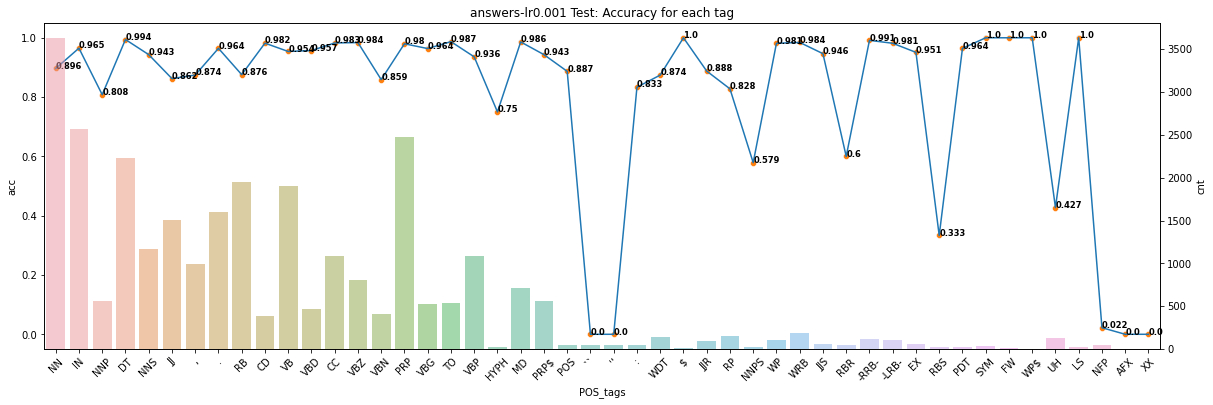

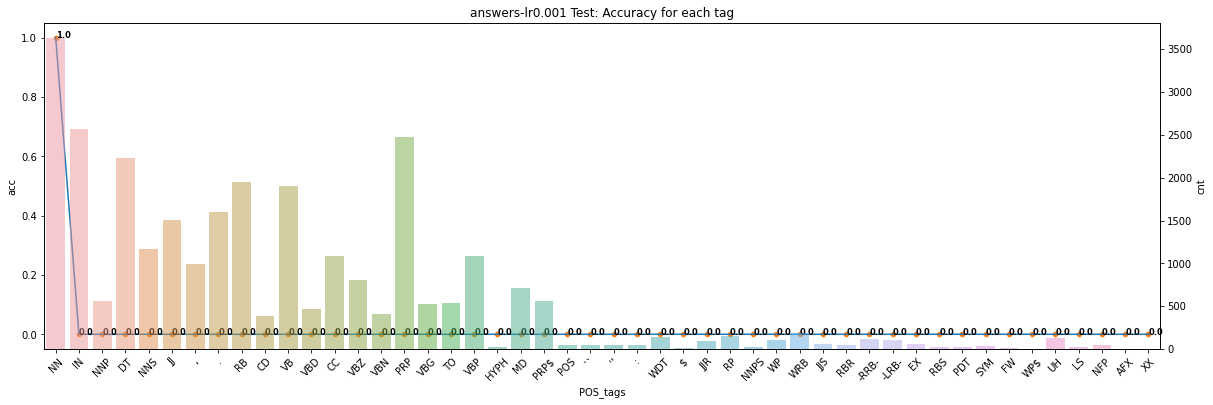

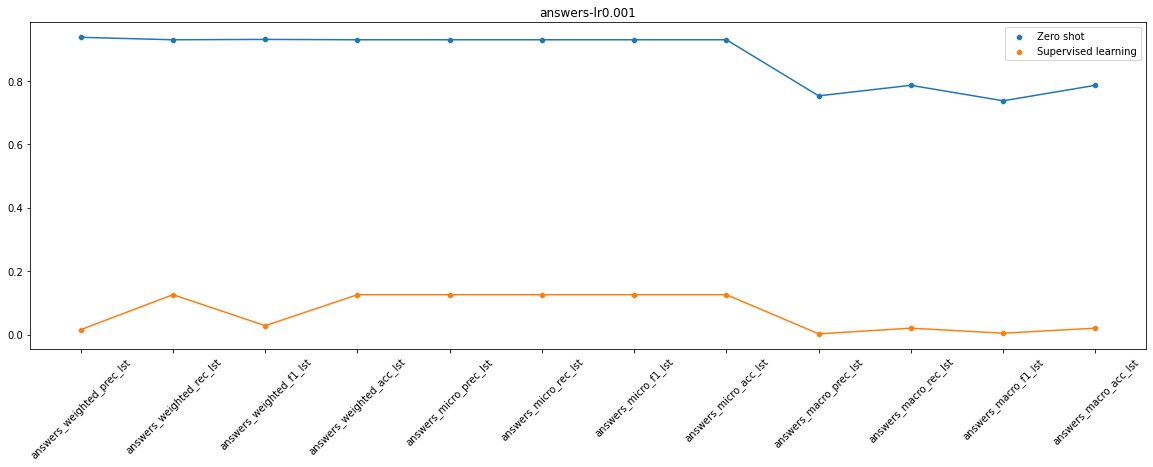

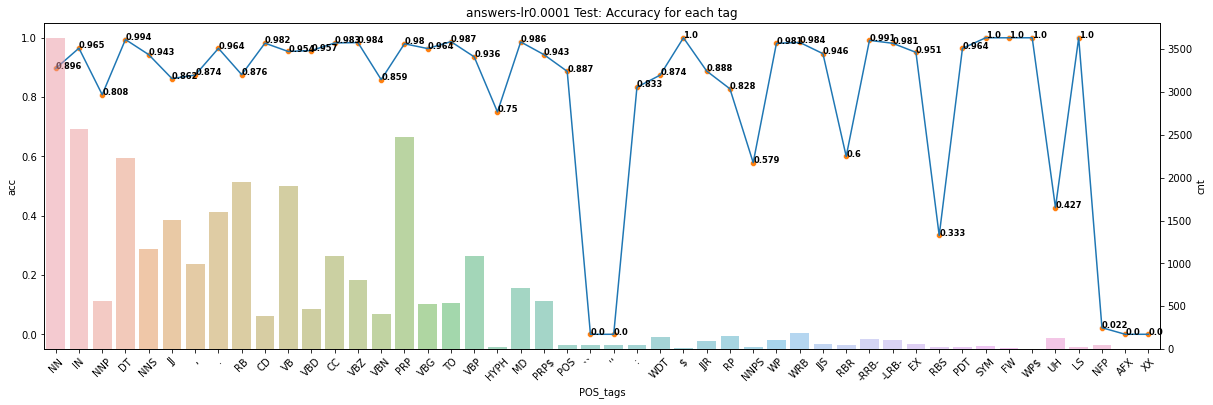

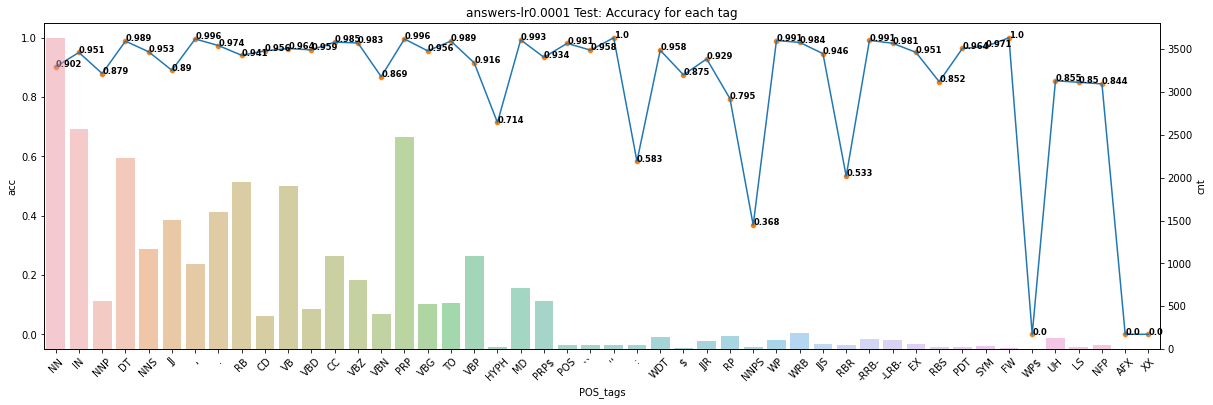

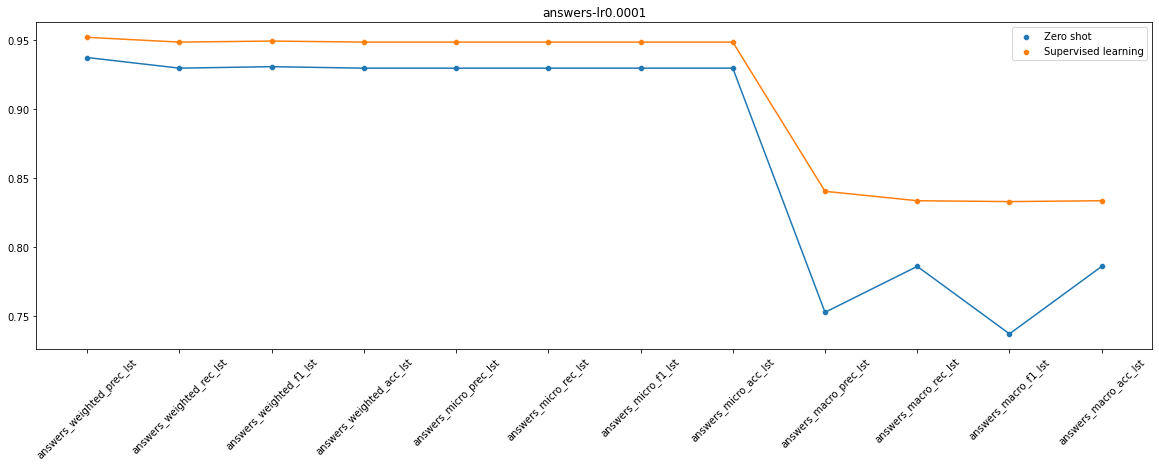

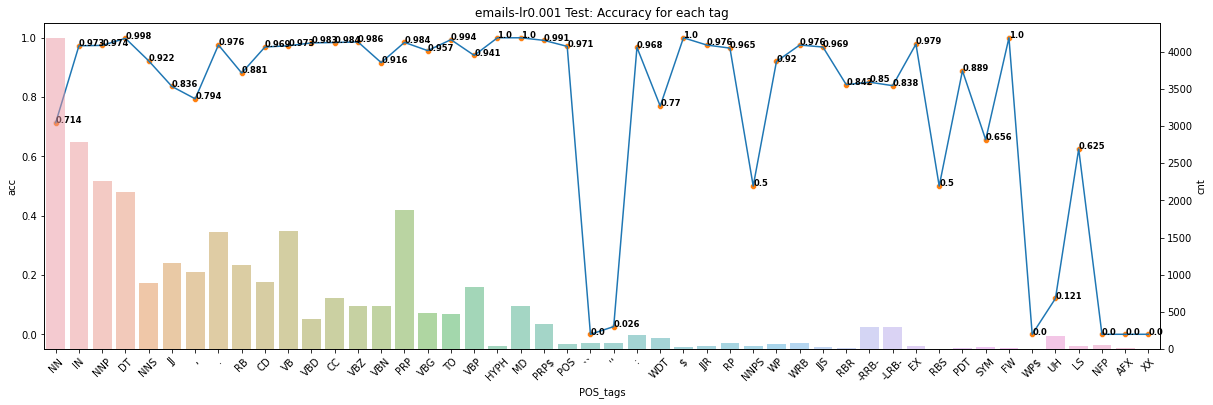

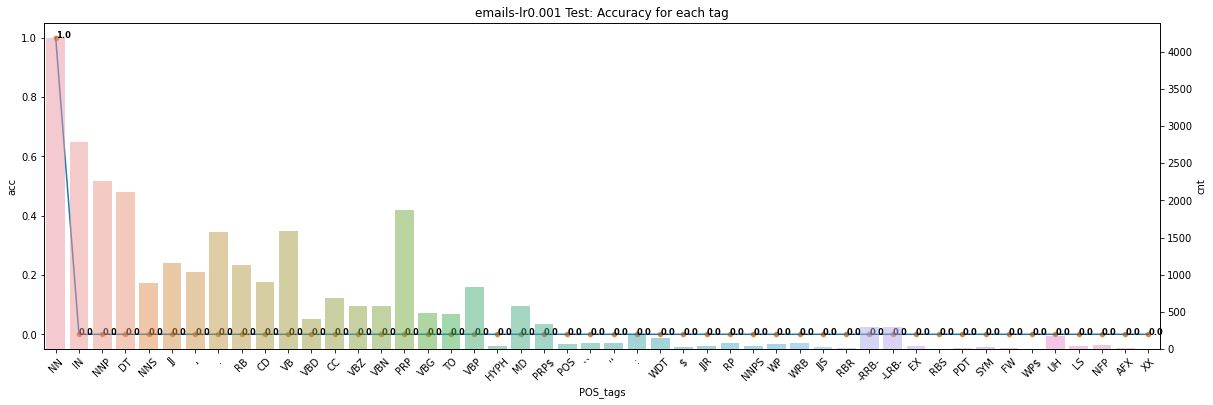

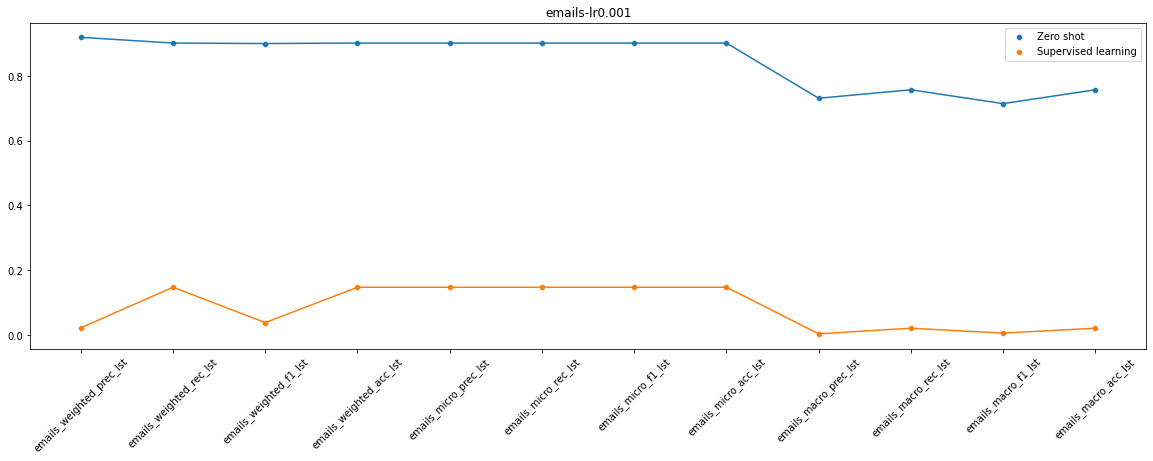

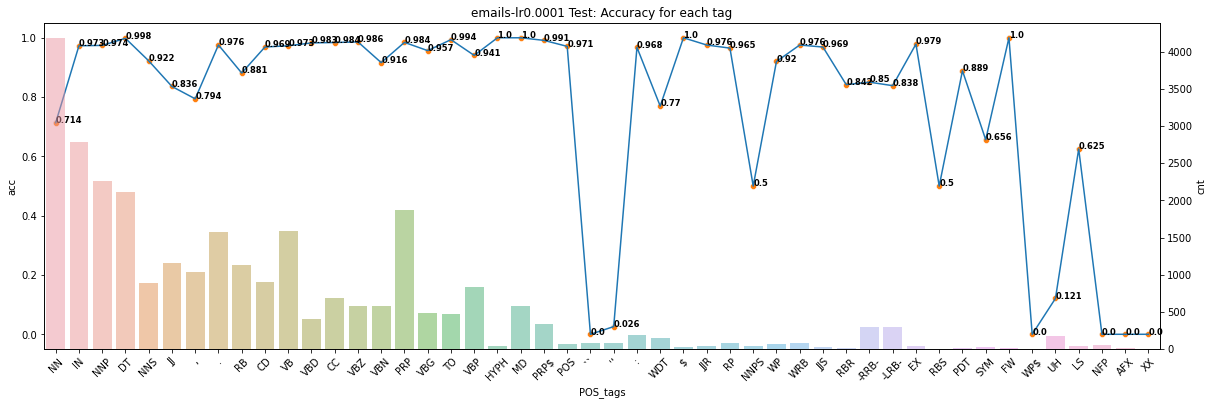

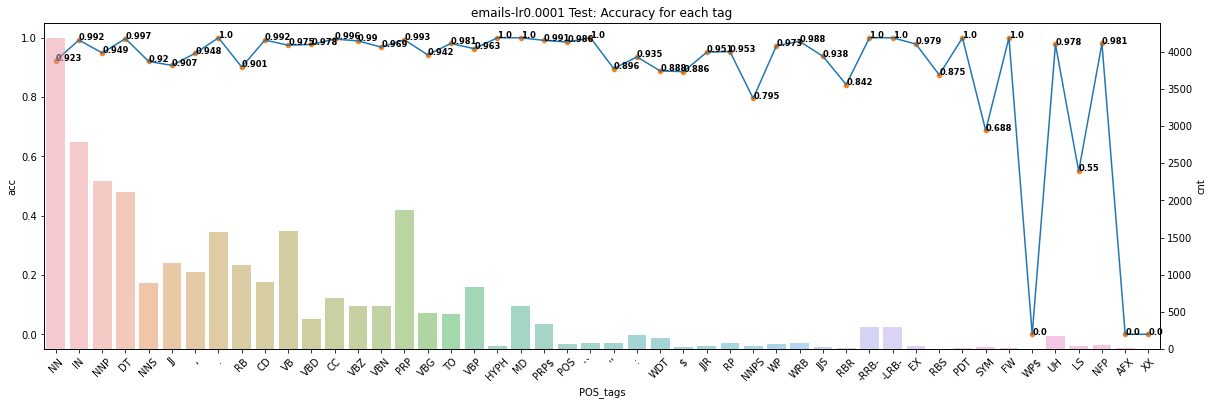

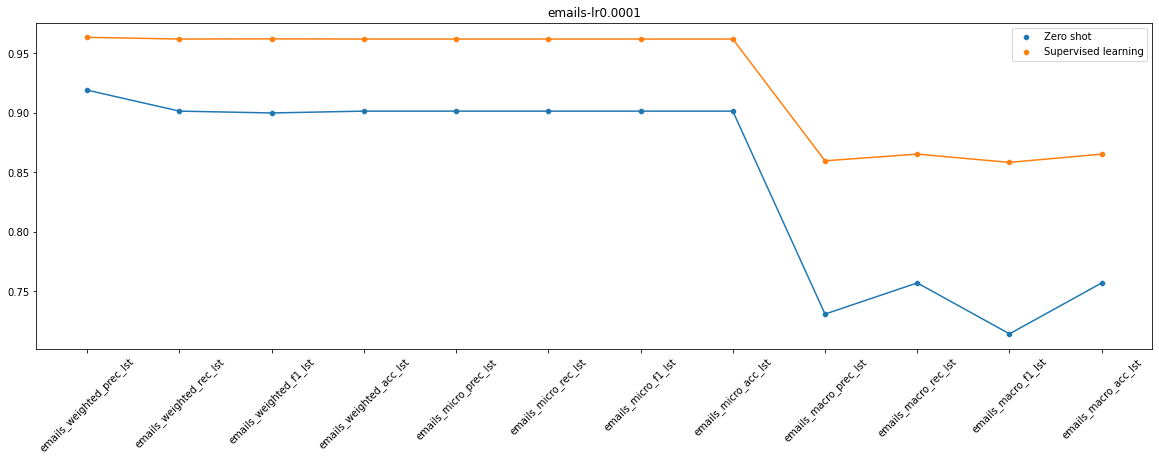

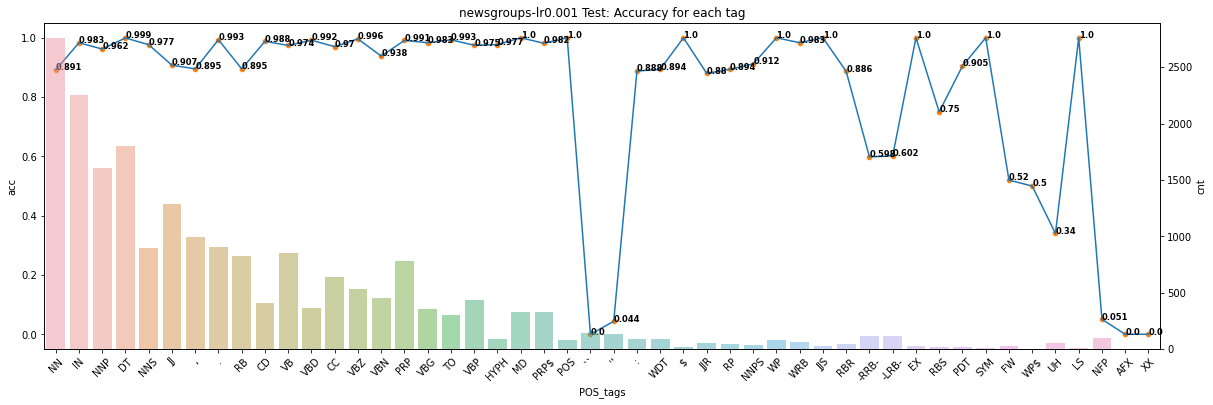

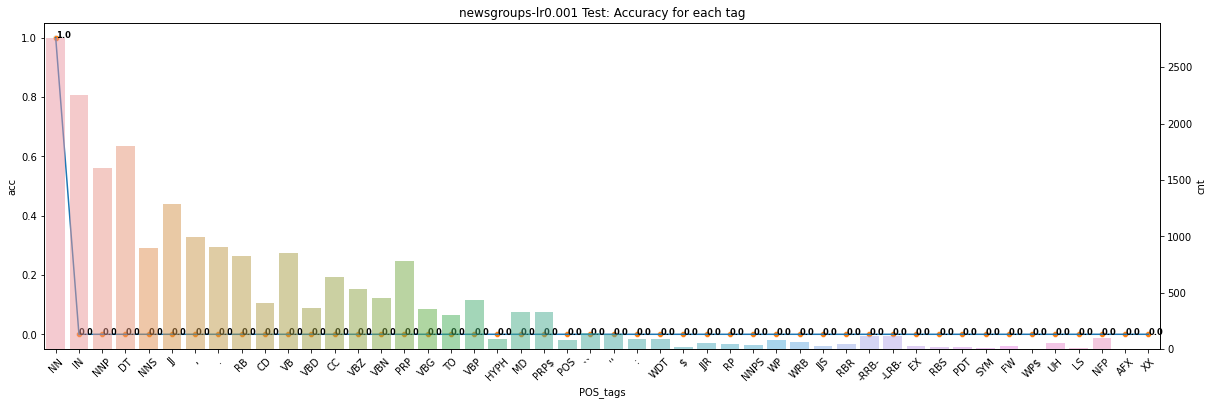

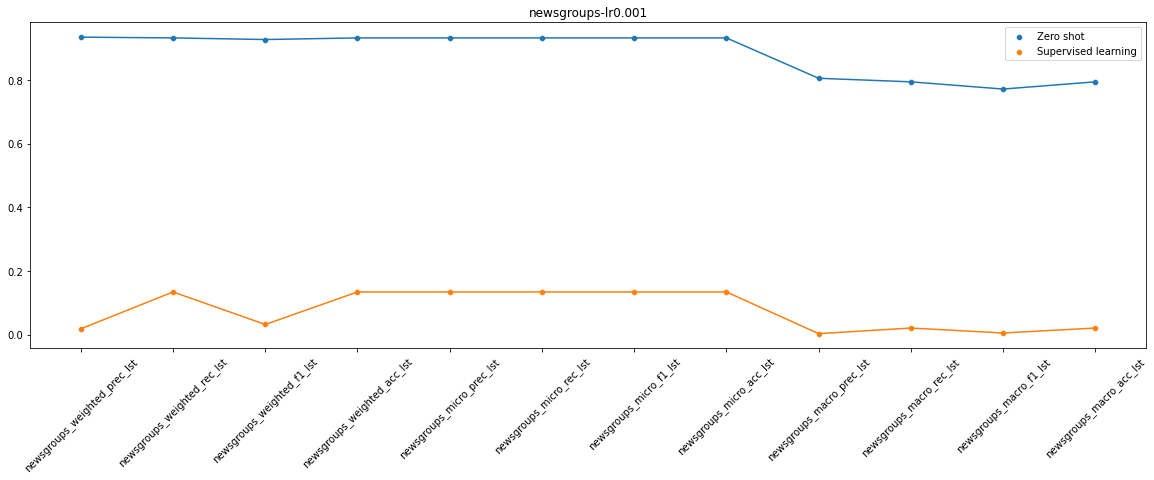

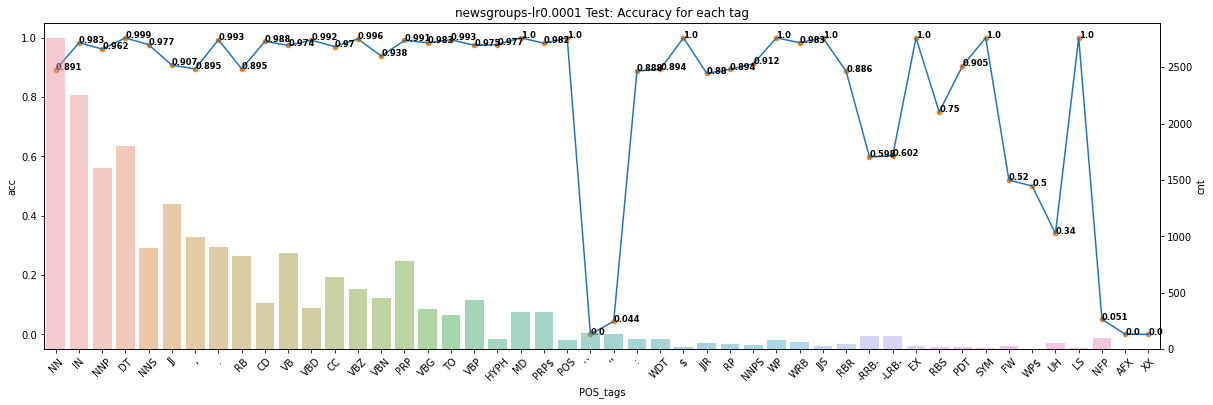

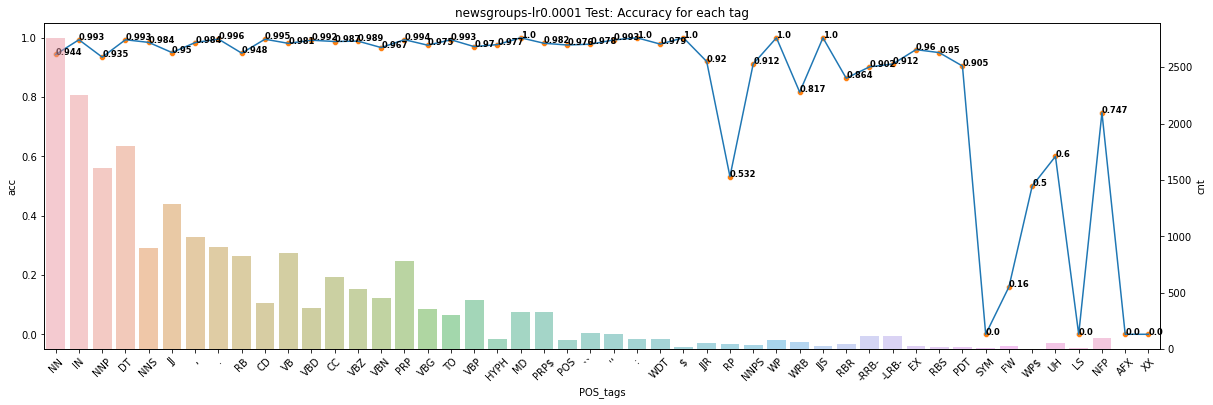

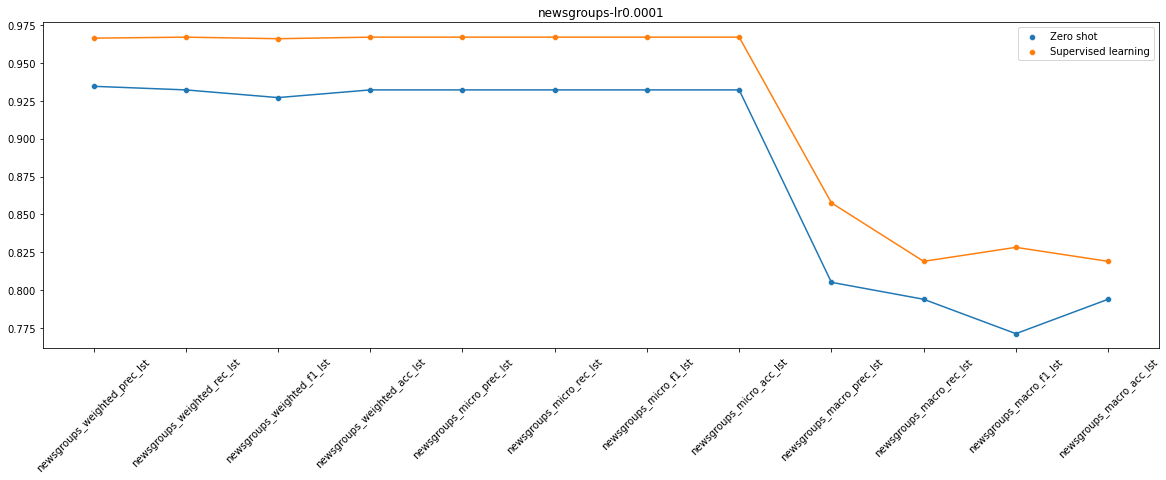

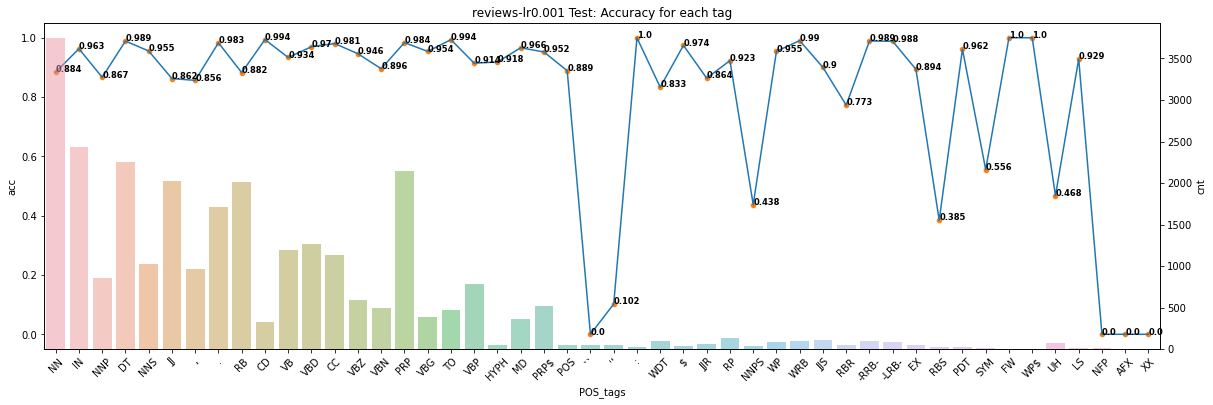

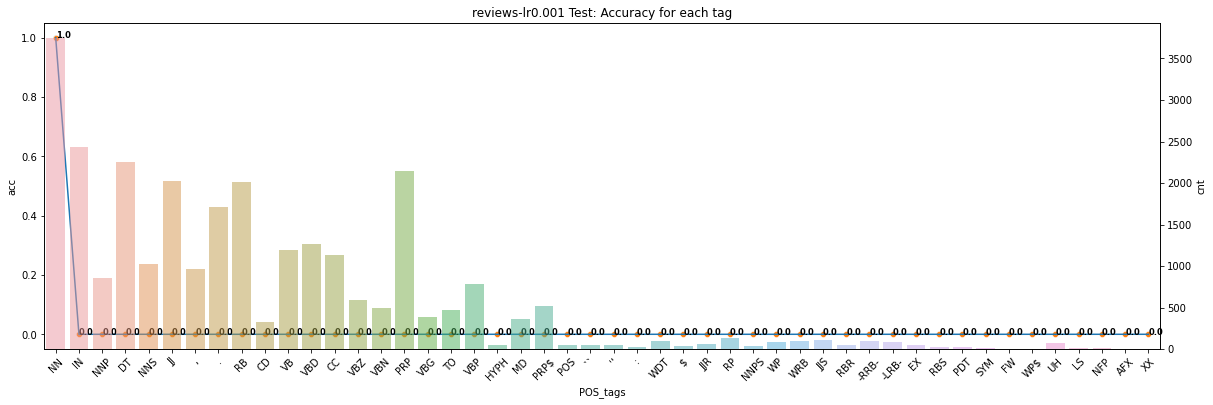

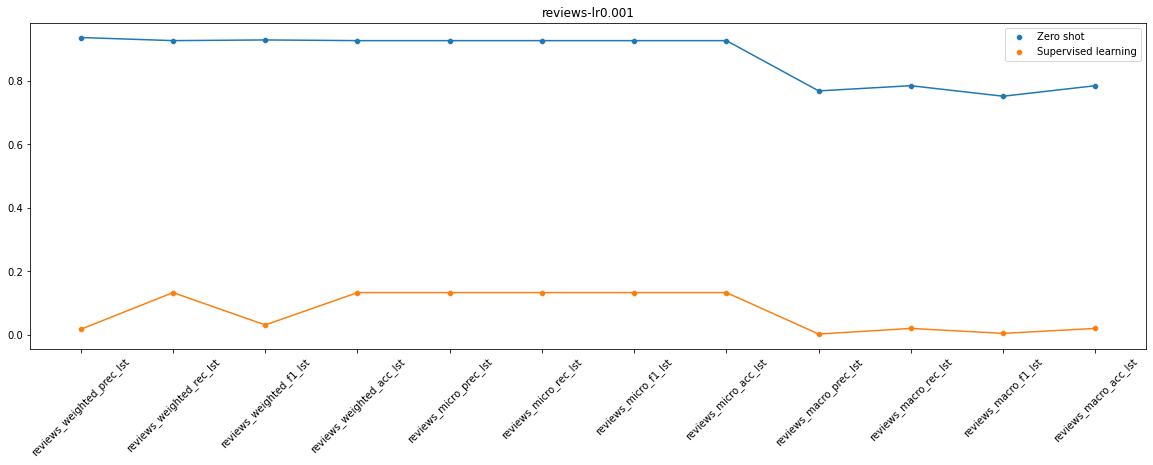

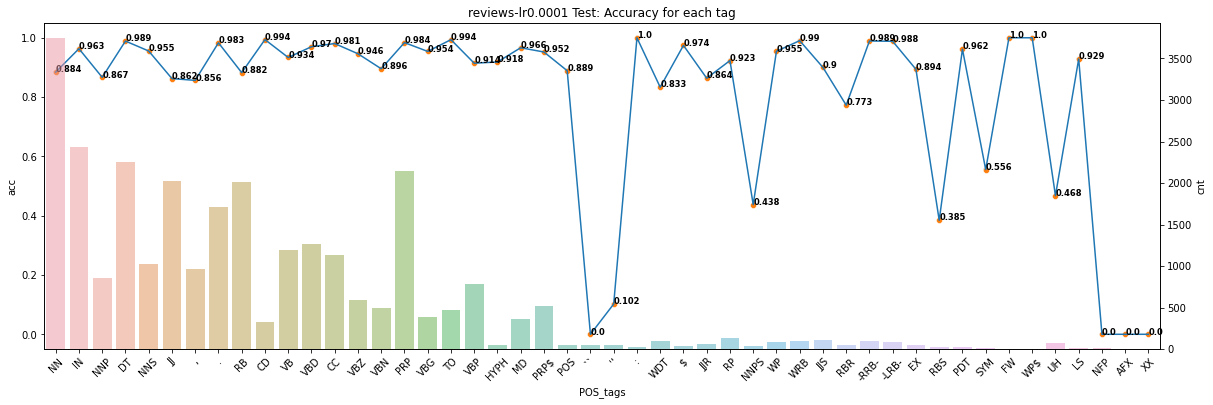

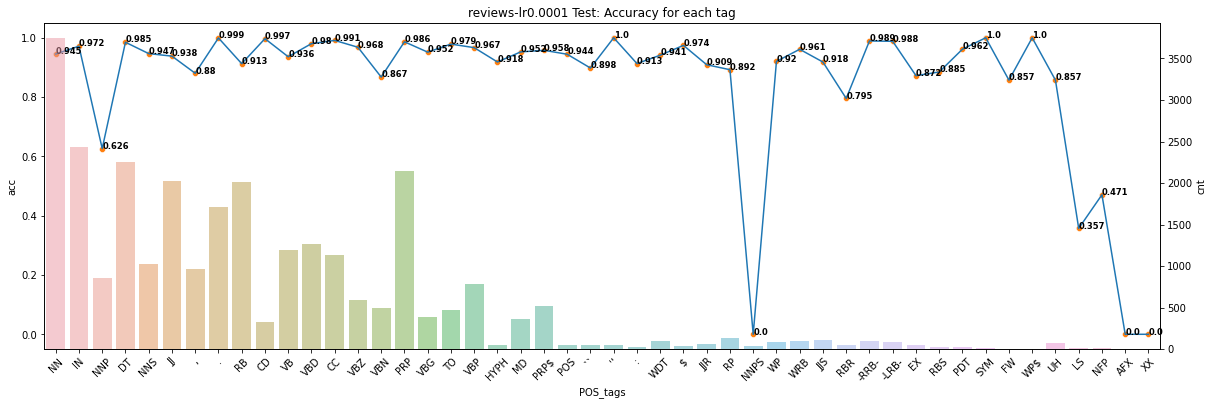

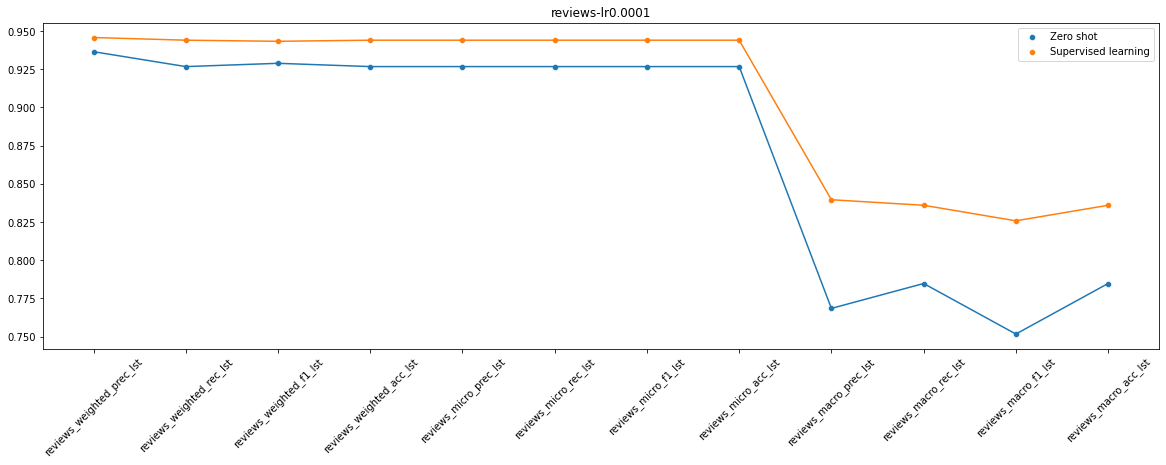

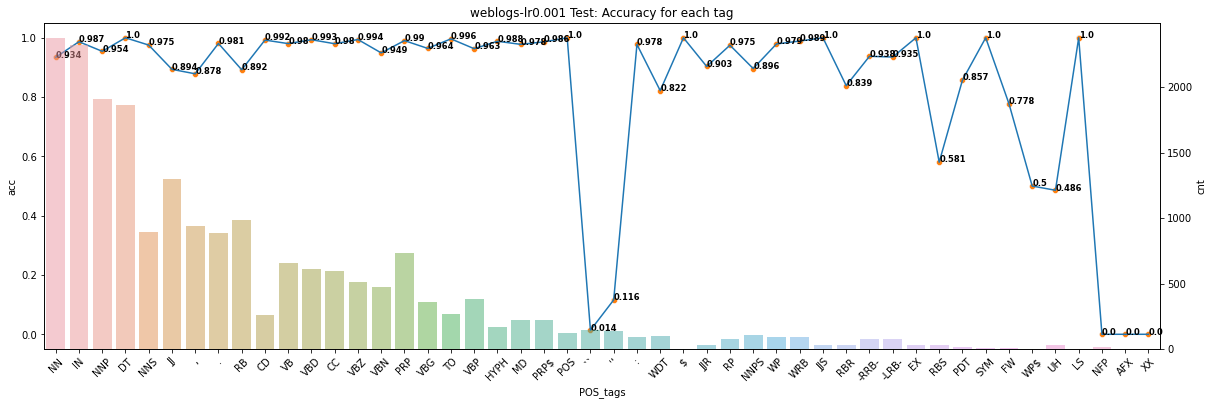

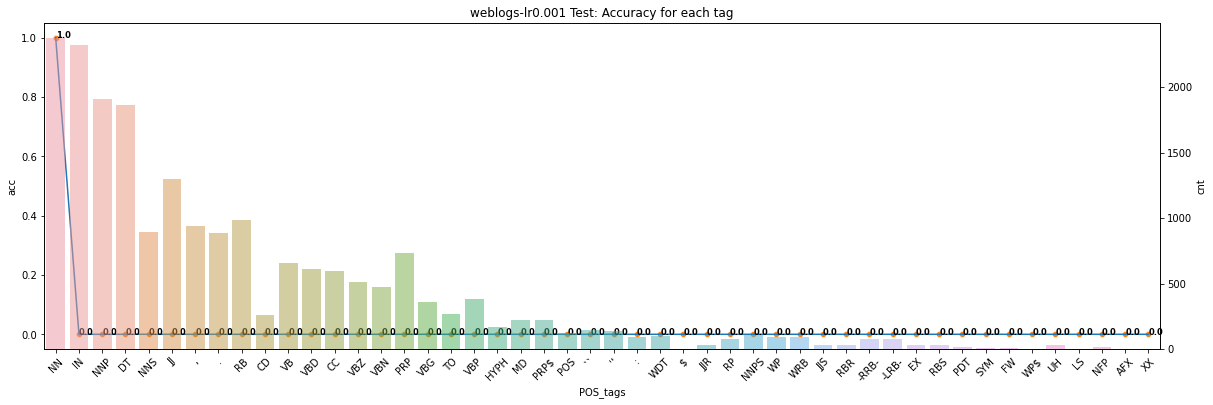

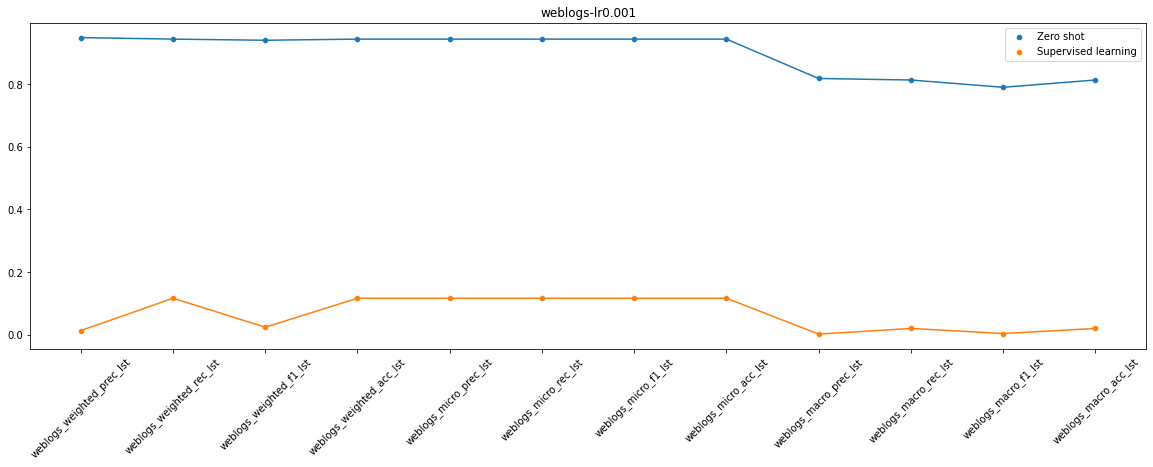

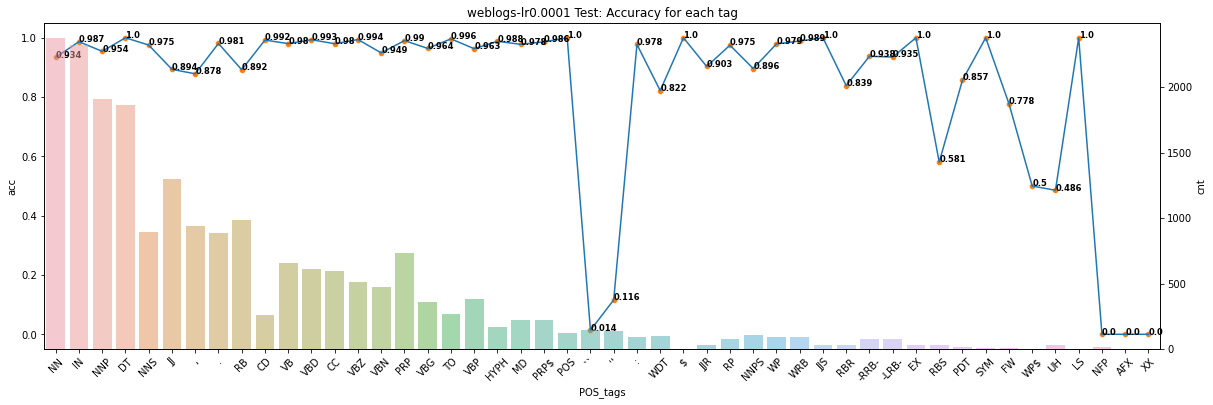

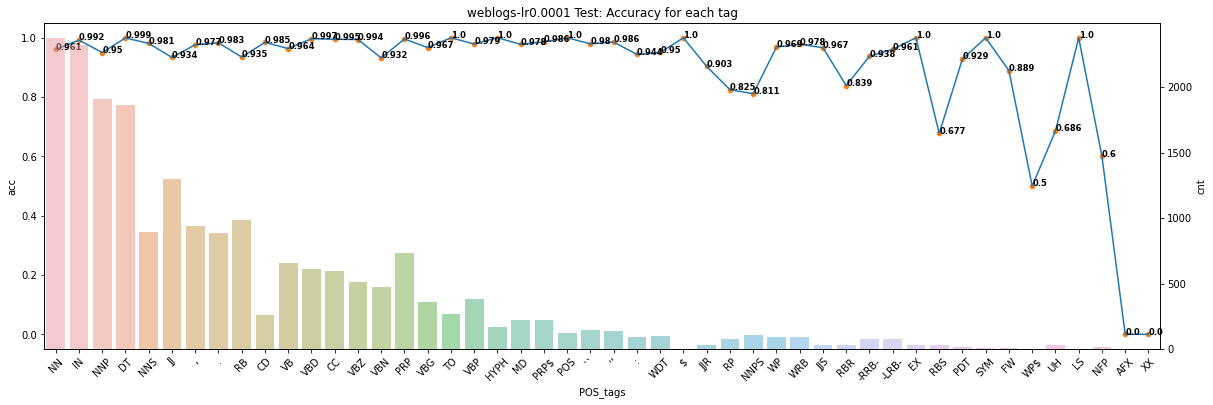

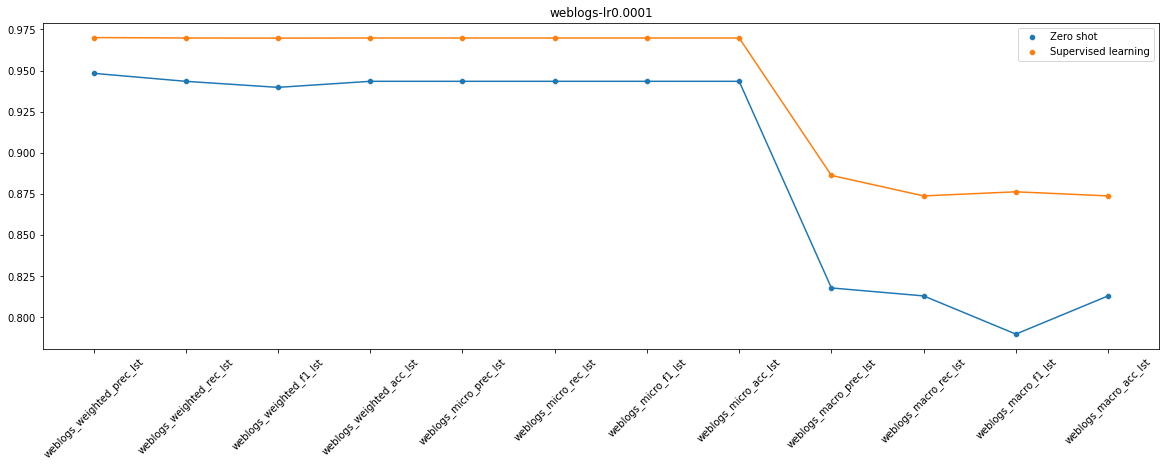

In [5]:
for domain in DOMAIN_LST:
  for lr in lr_lst:
    run_supservised_learning(domain, lr)